In [ ]:
import nltk;
nltk.download('stopwords')
import re
import numpy as np
import pandas as pd
from pprint import pprint
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
import json
import pickle
from google.colab import files
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
#%matplotlib inline
#pyLDAvis.enable_notebook()


import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

from nltk.corpus import stopwords


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
!pip install pyLDAvis

In [ ]:
uploaded = files.upload()

Saving Combined_test.csv to Combined_test.csv


In [ ]:
A = []
B=[]
C=[]


In [ ]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'gt', 'the'])


with open("Combined_test.csv") as f:
    for line in f:
        inner_list = [line.strip() for line in line.split(".")]

        C.append(inner_list)




In [ ]:

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(C))


# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

#print(trigram_mod[bigram_mod[data_words[0]]])

print("=========================================")

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = " ".join(sent)
        #texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out



/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [ ]:
print("============================================")
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# python3 -m spacy download en
#nlp = spacy.load('en', disable=['parser', 'ner'])

data_lemmatized = data_words
lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

#print(data_lemmatized[:1])

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]


In [ ]:

# View
#print(corpus[:1])
#print([[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]])

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=1000,
                                           passes=20,
                                           alpha='auto',
                                           per_word_topics=True)

pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]



pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)

[(0,
  '0.026*"it" + 0.024*"like" + 0.020*"get" + 0.011*"you" + 0.010*"right" + '
  '0.009*"even" + 0.008*"could" + 0.008*"well" + 0.008*"us" + 0.007*"just"'),
 (1,
  '0.019*"man" + 0.011*"something" + 0.010*"looking" + 0.009*"since" + '
  '0.009*"stream" + 0.009*"happy" + 0.009*"thing" + 0.009*"already" + '
  '0.008*"lol" + 0.008*"oh"'),
 (2,
  '0.019*"this" + 0.015*"one" + 0.014*"good" + 0.012*"we" + 0.011*"think" + '
  '0.011*"ve" + 0.010*"re" + 0.010*"time" + 0.010*"see" + 0.010*"great"'),
 (3,
  '0.020*"people" + 0.019*"really" + 0.014*"if" + 0.013*"going" + 0.011*"amp" '
  '+ 0.008*"phone" + 0.007*"workers" + 0.007*"there" + 0.007*"take" + '
  '0.007*"do"'),
 (4,
  '0.105*"rt" + 0.032*"the" + 0.025*"ai" + 0.023*"fintech" + 0.012*"amp" + '
  '0.011*"new" + 0.010*"via" + 0.009*"tech" + 0.009*"bigdata" + '
  '0.009*"insurtech"')]


In [ ]:
%%time
import gensim
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
lda = lda_model

CPU times: user 40.6 ms, sys: 5 ms, total: 45.6 ms
Wall time: 51.4 ms


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


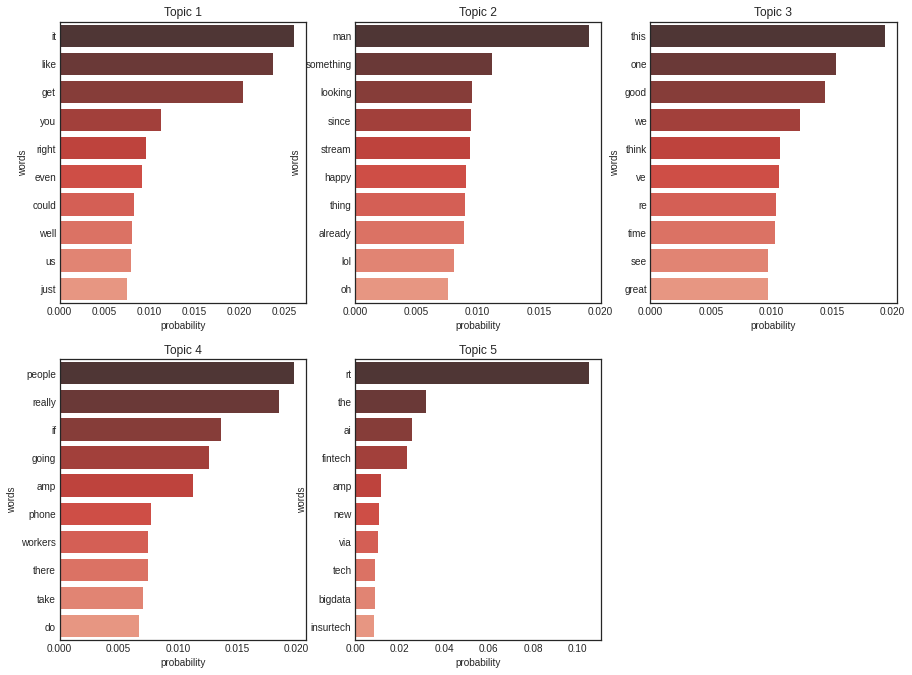

In [ ]:
plt.style.use('seaborn-white')
fiz=plt.figure(figsize=(15,30))
for i in range(5):
    df=pd.DataFrame(lda.show_topic(i), columns=['words','prob']).set_index('words')
#   df=df.sort_values('prob')
    
    plt.subplot(5,3,i+1)
    plt.title('Topic '+str(i+1))
    sns.barplot(x='prob', y=df.index, data=df, label='Cities', palette='Reds_d')
    plt.xlabel('probability')
    
plt.show()

In [ ]:
plt.savefig('movie_topics.png')

<Figure size 432x288 with 0 Axes>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
files.download('movie_topics.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>